In [62]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from pint import UnitStrippedWarning
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

warnings.simplefilter("ignore", category=UnitStrippedWarning)
xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [63]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/products/Hot_cmems_climato_2002_2014.zarr"
path_to_npp = "../../../1_data_processing/1_1_Forcing/products/Hot_observed_npp_climato.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/products/Hot_obs_zoo_climato_monthly_2002_2015.zarr"
export_file_name = "SeapoPym_HOT_climato_obs_npp_opti_all_parameters_2_groups"

In [64]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-02"
TIME_END = "2009-12-27"
STABILIZATION_TIME = 5
SAVE = True

## Loading


### Forcing


In [65]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 321kB
Dimensions:              (latitude: 1, longitude: 1, depth: 3, time: 1821)
Coordinates: (4)
Data variables: (13)

### Epipelagic layer


In [66]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

Magnitude,[[[113.10354321928514 114.18750083099961 113.81216693411004 ... 113.72807877620157 113.59442872389666 112.94051799923405]]]
Units,meter


<!-- ## Observed NPP -->


In [67]:
observed_npp = xr.open_zarr(path_to_npp)
observed_npp = observed_npp.sel(time=slice(TIME_START, TIME_END))
observed_npp = observed_npp.dropna("time", how="all")
observed_npp = observed_npp.resample(time="D").interpolate("linear")
observed_npp.load()

<xarray.Dataset> Size: 44kB
Dimensions:          (time: 1821, latitude: 1, longitude: 1)
Coordinates: (3)
Data variables: (2)
Attributes: (2)

### Observations


In [68]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]] [[[175.24749384551424]]] [[[169.028807463174]]] [[[183.22544878939186]]] [[[209.67444462420926]]] [[[249.67832901663408]]] [[[276.32712590507947]]] [[[288.4152516159477]]] [[[290.87610485890576]]] [[[309.7226737506274]]] [[[284.86368409190277]]] [[[250.8354669340342]]] [[[205.83324959699155]]] [[[169.5300410029905]]] [[[169.028807463174]]] [[[184.16566200957695]]] [[[208.84032451359002]]] [[[249.77746034277746]]] [[[274.8246466780064]]] [[[283.74409762470765]]] [[[288.36278273935625]]] [[[306.0065955062098]]] [[[291.278907182586]]] [[[246.83881007292297]]] [[[204.1907428435882]]]]
Units,milligram/meter2
Magnitude,[[[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.344131523354

Select the kind of observation you want to use.


In [69]:
# observations_selected = observations[["day_lowess_0.2", "night_lowess_0.2"]].rename(
#     {"day_lowess_0.2": "day", "night_lowess_0.2": "night"}
# )

observations_selected = observations[["day", "night"]]

Remove the X first months to let the model reach the stationary state.


In [70]:
observations_selected_without_init = observations_selected.isel(time=slice(STABILIZATION_TIME, None))
observations_selected_without_init

Magnitude,[[[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]] [[[173.55167845591396]]] [[[161.18085076616643]]] [[[179.1993152851171]]] [[[207.78348092804256]]] [[[256.97140808136334]]] [[[276.73713373591653]]] [[[286.8754053335449]]] [[[289.4875232614997]]] [[[315.3292764814672]]] [[[297.1327451472592]]] [[[252.05575513504192]]] [[[201.0579558457]]] [[[167.88955162294909]]] [[[161.18085076616643]]] [[[180.11886858075593]]] [[[206.9568833881889]]] [[[257.0734350236469]]] [[[275.23242516474]]] [[[282.22919058899055]]] [[[286.98619921530604]]] [[[311.5459297539875]]] [[[303.8242714951801]]] [[[248.03965495807626]]] [[[199.45355494862133]]]]
Units,milligram/meter2
Magnitude,[[[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]] [[[294.6494292157888]]] [[[258.03481873118506]]] [[[310.5038532805829]]] [[[339.1815897155657]]] [[[417.05656045622504]]] [[[416.24639799937876]]] [[[428.83910602723876]]] [[[450.3441315233542]]] [[[452.38484638704267]]] [[[411.10336607721837]]] [[[403.9301941931383]]] [[[354.5911867290542]]] [[[285.0364859453825]]] [[[258.03481873118506]]] [[[312.0971899578935]]] [[[337.83226845879244]]] [[[417.2221469934213]]] [[[413.983132804948]]] [[[421.89365674709336]]] [[[446.4529220074815]]] [[[446.9570956014589]]] [[[420.36154798665865]]] [[[397.4942208367208]]] [[[351.7616224091976]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [71]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=observed_npp["l12"], resolution=1 / 12, timestep=1),
)

2025-02-03 15:30:58,402 :: Seapodym ::  WARNING ::
|	l12 unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [72]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D1N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D1N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 100, 200),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=1,
        night_layer=0,
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("D2N1_tr_rate", -0.3, -0.001),
        tr_max=Parameter("D2N1_tr_max", 0, 50),
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 100, 200),
    ),
]

In [73]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations_selected_without_init)],
    standardize_rmse=True,
)

Set the genetic algorithm meta parameters.


In [147]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.15,
    INDPB=0.1,
    ETA=5,
    CXPB=0.7,
    NGEN=40,
    POP_SIZE=200,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [148]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [149]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
    logbook_path=f"{export_file_name}_logbook.json",
)

/Users/adm-lehodey/Documents/Workspace/Projects/Seapopym-optimisation/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning:

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51476 instead



And watch the magic on the Dask dashboard :


In [150]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:51476/status,
Dashboard: http://127.0.0.1:51476/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51477,Workers: 4
Dashboard: http://127.0.0.1:51476/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:51490,Total threads: 3
Dashboard: http://127.0.0.1:51494/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:51480,


## Run the optimization


In [151]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,-837.745001,1903.616435,-14092.621858,-0.164801,200,0.000
1,-115.558184,524.561596,-4585.126710,-0.068369,200,0.255
2,-28.390629,253.127333,-3382.003447,-0.055616,200,0.275
3,-4.618772,29.121677,-289.907819,-0.074650,200,0.205
4,-4.603764,26.768122,-232.917160,-0.089271,200,0.245
5,-1.809552,7.737029,-89.104071,-0.084527,200,0.250
6,-1.329914,6.309018,-74.585864,-0.084527,200,0.235
7,-0.473810,1.727531,-16.751153,-0.082953,200,0.250
8,-0.501546,2.564046,-32.373870,-0.085263,200,0.245


Generations: 100%|██████████| 10/10 [01:24<00:00,  8.41s/it]


## Optimization statistics


In [152]:
viewer.hall_of_fame.head(10)

D1N1_energy_coefficient  D1N1_tr_max  D1N1_tr_rate  \
generation individual                                                       
39         108                        0.399925    49.402263     -0.003191   
38         83                         0.399925    48.840487     -0.003191   
39         26                         0.397438    48.840487     -0.001973   
           20                         0.397438    49.402263     -0.003191   
           65                         0.397438    48.840487     -0.003191   
36         40                         0.397438    49.402263     -0.003191   
39         67                         0.397438    48.840487     -0.003191   
38         183                        0.397438    48.840487     -0.003191   
39         189                        0.397438    48.840487     -0.003191   
           32                         0.396918    49.402263     -0.003191   

                       D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
39         108                  102.662595             -0.188386   
38         83                   102.662595             -0.188386   
39         26                   104.466286             -0.188386   
           20                   102.662595             -0.188386   
           65                   102.662595             -0.188386   
36         40                   102.662595             -0.188386   
39         67                   102.662595             -0.188386   
38         183                  102.662595             -0.188386   
39         189                  102.662595             -0.188386   
           32                   102.662595             -0.188386   

                       D2N1_energy_coefficient  D2N1_tr_max  D2N1_tr_rate  \
generation individual                                                       
39         108                         0.18949    47.173383     -0.003616   
38         83                          0.18949    47.173383     -0.003616   
39         26                          0.18949    47.173383     -0.003616   
           20                          0.18949    47.173383     -0.003616   
           65                          0.18949    47.173383     -0.003616   
36         40                          0.18949    47.173383     -0.003616   
39         67                          0.18949    47.173383     -0.003616   
38         183                         0.18949    47.173383     -0.003616   
39         189                         0.18949    47.173383     -0.003616   
           32                          0.18949    47.173383     -0.003616   

                       D2N1_inv_lambda_max  D2N1_inv_lambda_rate   fitness  
generation individual                                                       
39         108                  139.727925             -0.233893  0.021610  
38         83                   139.727925             -0.233893  0.021610  
39         26                   139.727925             -0.233893  0.021636  
           20                   139.727925             -0.233893  0.021675  
           65                   139.727925             -0.233893  0.021675  
36         40                   139.727925             -0.233893  0.021675  
39         67                   139.727925             -0.233893  0.021675  
38         183                  139.727925             -0.233893  0.021675  
39         189                  139.727925             -0.233893  0.021675  
           32                   139.727925             -0.233893  0.021711

In [153]:
viewer.fitness_evolution()

In [154]:
viewer.parameters_standardized_deviation()

In [179]:
fig = px.scatter_matrix(
    viewer.hall_of_fame[:4000],
    dimensions=viewer.hall_of_fame.columns[:-1],
    height=1500,
    width=1500,
    color="fitness",
    color_continuous_scale=[
        (0, "rgba(0,0,255,1)"),
        (0.3, "rgba(255,0,0,0.8)"),
        (1, "rgba(255,255,255,0.0)"),
    ],
)
# fig.update_traces(
#     showupperhalf=False,
# )
# change la taille des points
fig.update_traces(
    marker={"size": 3},
    unselected={"marker": {"opacity": 0.01}},
)

param_bounds = {
    k: (v.lower_bound, v.upper_bound)
    for k, v in cost_function.functional_groups.unique_functional_groups_parameters_ordered.items()
}
for i, param_name in enumerate(viewer.hall_of_fame.columns[:-1]):
    lower_bound = param_bounds[param_name][0]
    upper_bound = param_bounds[param_name][1]
    fig.update_xaxes(range=[lower_bound, upper_bound], row=i + 1, col=i + 1)

fig

In [156]:
viewer.box_plot(5, nbest=1000)

In [157]:
groups = [
    ["D1N1_energy_coefficient", "D1N1_tr_rate", "D1N1_tr_max", "D1N1_inv_lambda_rate", "D1N1_inv_lambda_max"],
    ["D2N1_energy_coefficient", "D2N1_tr_rate", "D2N1_tr_max", "D2N1_inv_lambda_rate", "D2N1_inv_lambda_max"],
]
fig = viewer.parallel_coordinates(
    nbest=2000,
    unselected_opacity=0,
    parameter_groups=groups,
)

In [158]:
for group in fig:
    display(group)

In [159]:
if SAVE:
    for i, trace in enumerate(fig):
        trace.write_html(f"Parallel_coordinates_{export_file_name}_{i}.html")

# Prepare results for ploting


## Run simulation with original parameters


In [160]:
original_config = [[0, 0, 0.1668, 10.38, -0.11, 150, -0.15]]
print(f"Original configuration: {list(original_config[0])}")

Original configuration: [0, 0, 0.1668, 10.38, -0.11, 150, -0.15]


In [161]:
original_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=original_config, groups_name=["Total"]),
)

original_model.run()

## Run simulation with optimized parameters


In [162]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")
print(f"Best individual: {list(best_individual[1])}")

Best individual: [0.0, 0.0, 0.39992507271615124, 49.402263241438796, -0.0031910215000000002, 102.6625945406, -0.1883860685]
Best individual: [1.0, 0.0, 0.1894897583, 47.173383154498644, -0.003616146, 139.7279249696, -0.2338925734]


In [163]:
best_model = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1", "D2N1"]),
)

best_model.run()

And with the X best individuals :


In [164]:
NB_INDIVIDUAL_TO_SHOW = 10

min_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
max_biomass_D1N1 = best_model.export_biomass().sel(functional_group=0).data.flatten()
min_biomass_D2N1 = best_model.export_biomass().sel(functional_group=1).data.flatten()
max_biomass_D2N1 = best_model.export_biomass().sel(functional_group=1).data.flatten()

biomass_accumulated = []

for cpt in range(0, NB_INDIVIDUAL_TO_SHOW):
    individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[cpt])
    model = wrapper.model_generator_no_transport(
        forcing_parameters=forcing_parameters,
        fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=individual, groups_name=["D1N1", "D2N1"]),
    )
    model.run()

    biomass_accumulated.append(model.export_biomass().expand_dims({"individual": [cpt]}))

In [165]:
with xr.set_options(keep_attrs=True):
    best_individuals_simulations = xr.concat(biomass_accumulated, dim="individual")
    min_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D1N1 = (
        best_individuals_simulations.sel(functional_group=0).max("individual").isel(latitude=0, longitude=0)
    )
    min_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).min("individual").isel(latitude=0, longitude=0)
    )
    max_biomass_D2N1 = (
        best_individuals_simulations.sel(functional_group=1).max("individual").isel(latitude=0, longitude=0)
    )

### Format the results


Convert to pandas series.


In [166]:
optimized_biomass_pandas = (
    best_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
original_biomass_pandas = (
    original_model.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_day_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .day.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["day"]
)
observations_night_pandas = (
    observations_selected_without_init.pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .night.dropna("time")
    .to_dataframe()
    .reset_index()
    .set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [167]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = optimized_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

monthly_pred_d2n1 = optimized_biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_pred_orignal = original_biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_orignal.index = monthly_pred_orignal.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

# Plot


### Correlation matrix of X best individuals


In [168]:
NB_INDIVIDUAL_CORRELATION = 2000

indiv_param = viewer.hall_of_fame.iloc[:NB_INDIVIDUAL_CORRELATION, :-1].to_numpy()
param_names = viewer.hall_of_fame.columns[:-1]

corr_matrix = np.corrcoef(indiv_param.T)
np.fill_diagonal(corr_matrix, np.nan)

fig = px.imshow(
    corr_matrix,
    text_auto=False,
    aspect="auto",
    color_continuous_scale=[[0, "blue"], [0.5, "white"], [1, "red"]],
    zmin=-1,
    zmax=1,
    x=param_names,
    y=param_names,
)
fig.update_layout(
    title="Correlation Matrix of Hall of Fame Parameters (Lower Triangle)",
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    xaxis={"showgrid": False, "tickangle": -35},
    yaxis={"showgrid": False},
)

fig.show()

In [169]:
if SAVE:
    fig.write_html(f"Correlation_best_individuals_{export_file_name}.html")

### Daily with best individuals


In [170]:
x = best_model.export_biomass().time.to_series()
x_rev = pd.concat([x, x[::-1]])

fig = go.Figure()

# D1N1 data
y_D1N1 = (
    best_model.export_biomass()
    .sel(functional_group=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
)
y_D1N1_upper = max_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")
y_D1N1_lower = min_biomass_D1N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1]
y_D1N1_rev = np.concatenate([y_D1N1_upper, y_D1N1_lower])

# D2N1 data
y_D2N1 = (
    best_model.export_biomass()
    .sel(functional_group=1)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    .data.flatten()
) + y_D1N1
y_D2N1_upper = max_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2") + y_D1N1_upper
y_D2N1_lower = min_biomass_D2N1.pint.quantify().pint.to("milligram / meter ** 2")[::-1] + y_D1N1_lower
y_D2N1_rev = np.concatenate([y_D2N1_upper, y_D2N1_lower])

fig = go.Figure()

# D1N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D1N1_rev,
        fill="toself",
        fillcolor="rgba(255,0,0,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D1N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D1N1,
        line_color="rgb(255,0,0)",
        name="D1N1 : Best individual",
    )
)

# D2N1 traces
fig.add_trace(
    go.Scatter(
        x=x_rev,
        y=y_D2N1_rev,
        fill="toself",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name=f"D2N1 : {NB_INDIVIDUAL_TO_SHOW} best individuals",
    )
)

fig.add_trace(
    go.Scatter(
        x=x,
        y=y_D2N1,
        line_color="rgb(0,176,246)",
        name="D2N1 : Best individual",
    )
)

# OBSERVATIONS ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=observations_selected_without_init.day.time.data.flatten(),
        y=observations_selected_without_init.day.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Day observations",
        line={"dash": "dash", "color": "firebrick", "width": 1},
    )
)

fig.add_trace(
    go.Scatter(
        x=observations_selected_without_init.night.time.data.flatten(),
        y=observations_selected_without_init.night.pint.quantify().pint.to("mg/m2").pint.dequantify().data.flatten(),
        mode="lines+markers",
        name="Night observations",
        line={"dash": "dash", "color": "royalblue", "width": 1},
    )
)

# PRIMARY PRODUCTION ----------------------------------------- #

fig.add_trace(
    go.Scatter(
        x=best_model.state.primary_production.time.data.flatten(),
        y=best_model.state.primary_production.pint.quantify().pint.to("mg/m2/day").pint.dequantify().data.flatten(),
        mode="lines",
        name="Primary Production (mg/m2/day)",
        line={"dash": "dot", "color": "green", "width": 1},
    )
)

fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Biomass (mg/m2)",
    title=f"Biomass over Time (Daily) : {export_file_name}",
    showlegend=True,
)

fig.show()

In [171]:
if SAVE:
    fig.write_html(f"Biomass_best_individuals_{export_file_name}.html")

### Monthly with original parameters


In [172]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)

# DAY ------------------------------------------------ #

fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        mode="lines",
        line={"color": "rgb(255,0,0)"},
        name="Predictions Day",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill="tonextx",
        fillcolor="rgba(255,0,0,0.15)",
        mode="lines+markers",
        line={"color": "firebrick", "dash": "dash", "width": 1},
        name="Observations (day)",
    )
)
# Night ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
        y=(monthly_pred_d1n1 + monthly_pred_d2n1),
        mode="lines",
        line={"color": "rgb(0,176,246)"},
        name="Predictions Night",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonextx",
        fillcolor="rgba(0,176,246,0.15)",
        mode="lines+markers",
        line={"color": "royalblue", "dash": "dash", "width": 1},
        name="Observations (night)",
    )
)

# LMTL ------------------------------------------------ #
fig.add_trace(
    go.Scatter(
        x=monthly_pred_orignal.index,
        y=monthly_pred_orignal,
        mode="lines",
        line={"color": "grey"},
        name="Predictions Original",
    )
)


# LAYER ------------------------------------------------ #

fig.add_trace(px.line(monthly_layer).data[0])

fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dot"},
)
fig.update_layout(
    yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"},
    height=600,
)
fig.update_layout(legend={"y": 1.0, "x": 1.1})
fig.show()

In [173]:
if SAVE:
    fig.write_html(f"Biomass_monthly_with_original_{export_file_name}.html")

### Taylor Diagram


correlation [0.9353149872077298, 0.9312914689779099, 0.76527624373704, 0.7816689576347313]
norm STD [0.6545402869517987, 1.095882336531026, 1.0904331325833256, 0.9321094452265478]
bias [0.07240804598381442, 0.06839472715601205, 0.7775198894747717, -1.613795255259677]
NRMSE [0.4516860713021954, 0.39973285265393604, 0.7211652190281521, 0.6415808452386155]
name ['HOT Day', 'HOT Night', 'Original Day', 'Original Night']


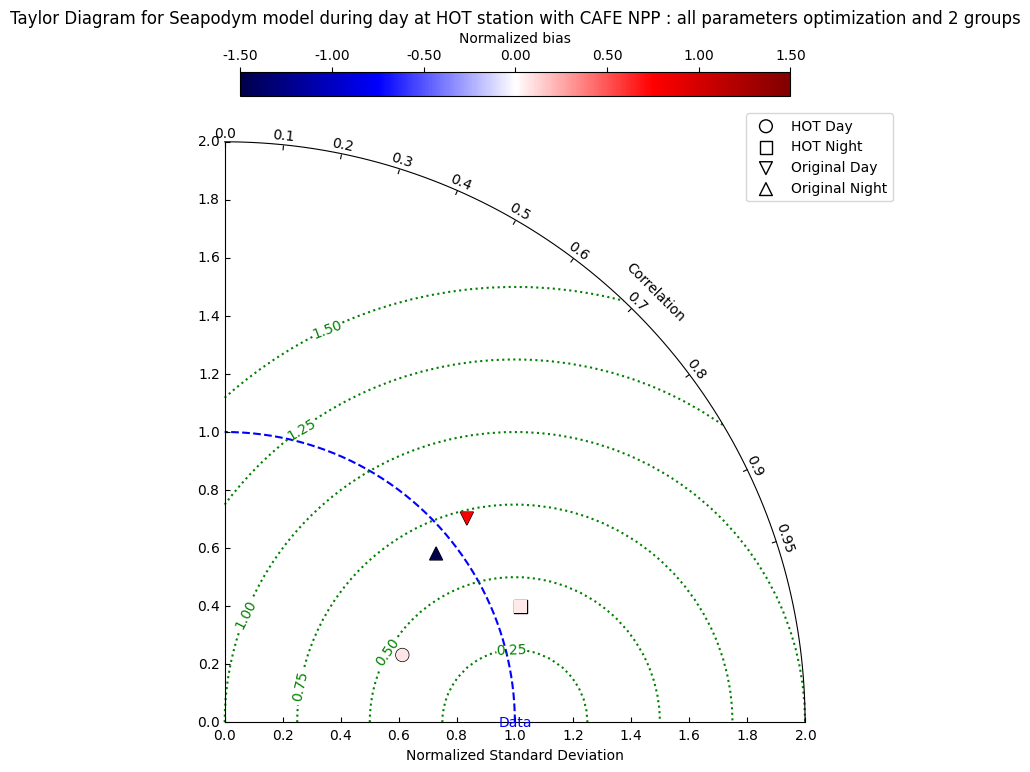

In [174]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1, monthly_pred_d1n1 + monthly_pred_d2n1, monthly_pred_orignal, monthly_pred_orignal]
all_obs = [monthly_obs_day, monthly_obs_night, monthly_obs_day, monthly_obs_night]

all_names = ["HOT Day", "HOT Night", "Original Day", "Original Night"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model during day at HOT station with CAFE NPP : all parameters optimization and 2 groups"
)

# export the figure
if SAVE:
    plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [175]:
if SAVE:
    diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.935315,0.654540,0.072408,0.451686
1,HOT Night,0.931291,1.095882,0.068395,0.399733
2,Original Day,0.765276,1.090433,0.777520,0.721165
3,Original Night,0.781669,0.932109,-1.613795,0.641581


### Telagrand diagram


In [176]:
# Quantify and convert observations to mg/m2
obs_day = (
    observations_selected_without_init.day.isel(latitude=0, longitude=0, layer=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert predictions to mg/m2
pred_day = (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=0)
    .sel(time=obs_day.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for day observations
all_ranks_day = []
for time_ite in obs_day.time:
    pred_day_ite = np.sort(pred_day.sel(time=time_ite).data)
    obs_day_ite = float(obs_day.sel(time=time_ite))
    rank = np.searchsorted(pred_day_ite, obs_day_ite)
    all_ranks_day.append(rank)

# Quantify and convert night observations to mg/m2
obs_night = (
    observations_selected_without_init.night.isel(latitude=0, longitude=0, layer=0)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
    # .resample(time="1D")
    # .interpolate("linear")
)

# Select and convert night predictions to mg/m2
pred_night = pred_day + (
    best_individuals_simulations.isel(latitude=0, longitude=0, functional_group=1)
    .sel(time=obs_night.time)
    .pint.quantify()
    .pint.to("mg/m2")
    .pint.dequantify()
)

# Calculate ranks for night observations
all_ranks_night = []
for time_ite in obs_night.time:
    pred_night_ite = np.sort(pred_night.sel(time=time_ite).data)
    obs_night_ite = float(obs_night.sel(time=time_ite))
    rank = np.searchsorted(pred_night_ite, obs_night_ite)
    all_ranks_night.append(rank)

In [177]:
fig = go.Figure()


value, count = np.unique(all_ranks_day, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Day Ranks",
        marker_color="firebrick",
        opacity=0.75,
    )
)

value, count = np.unique(all_ranks_night, return_counts=True)
count = count / count.sum()
fig.add_trace(
    go.Bar(
        x=value,
        y=count,
        name="Night Ranks",
        marker_color="royalblue",
        opacity=0.75,
    )
)

# Update layout
fig.update_layout(
    title="Histogram of Ranks for Day and Night",
    xaxis_title="Rank",
    yaxis_title="P(Rank)",
    barmode="group",
)

fig.show()

In [178]:
if SAVE:
    fig.write_html(f"Telagrand_diagram_{export_file_name}.html")